In [16]:
# NHANES 2021–2023 Inferential Assignment
# Nabiha Chaudhry

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

print("libraries loaded.")

libraries loaded.


In [4]:
#load xpt files

demo_set = pd.read_sas('DEMO_L.xpt')
bpxo_set = pd.read_sas('BPXO_L.xpt')
hepb_set = pd.read_sas('HEPB_S_L.xpt')
vitd_set = pd.read_sas('VID_L.xpt')
kiq_set = pd.read_sas('KIQ_U_L.xpt')
paq_set = pd.read_sas('PAQ_L.xpt')
whq_set = pd.read_sas('WHQ_L.xpt')

In [5]:
# merge datasets on SEQN
df = demo_set.merge(bpxo_set, on='SEQN', how='left')
df = df.merge(hepb_set, on='SEQN', how='left')
df = df.merge(vitd_set, on='SEQN', how='left')
df = df.merge(kiq_set, on='SEQN', how='left')
df = df.merge(paq_set, on='SEQN', how='left')
df = df.merge(whq_set, on='SEQN', how='left')

In [22]:
# keep only variables we need
cols = ['SEQN','DMDMARTZ','DMDEDUC2','RIDAGEYR','BPXOSY3',
        'BPXODI3','LBDVD2LC','LBXHBS','KIQ022','PAD680','WHD020']
data = df[cols].copy()

# Clean continuous variables
df = df[(df['PAD680'] < 7777) & (df['WHD020'] < 7777)]
df = df.dropna(subset=['PAD680', 'WHD020', 'RIDAGEYR', 'BPXOSY3', 'BPXODI3'])

# data cleaning
for col in ['PAD680','WHD020']:
    data[col] = data[col].replace([7777,9999], np.nan)
data = data.dropna(subset=['DMDMARTZ','DMDEDUC2','PAD680','WHD020','BPXOSY3','RIDAGEYR'])

# Marital status: married vs. not married
# Reference: DMDMARTZ (1=Married, 2=Widowed, 3=Divorced, 4=Separated, 5=Never married, 6=Living with partner)
data['married'] = np.where(data['DMDMARTZ']==1, 'Married', 'Not married')

# Education: bachelor’s or higher vs. less than bachelor’s
# Reference: DMDEDUC2 (5=Bachelor’s, 7=Refused, 9=Don’t know)
data['education'] = np.where(data['DMDEDUC2']>=5, 'Bachelor+','Less than bachelor')

# Kidney status: KIQ022 (1=Yes, 2=No)
data['kidney'] = np.where(data['KIQ022']==1, 'Yes','No')

# Quick check
print(data[['married','education','kidney']].head())


       married           education kidney
0      Married           Bachelor+     No
1      Married           Bachelor+     No
2      Married  Less than bachelor     No
8      Married  Less than bachelor     No
9  Not married           Bachelor+     No


In [14]:
# Question 1
# Is there an association between marital status (married or not married)
# and education level (bachelor’s degree or higher vs. less than bachelor’s degree)?
ct = pd.crosstab(data['married'], data['education'])
chi2, p, dof, ex = stats.chi2_contingency(ct)
print("Question 1: Chi-square Test")
print(ct)
print("Chi-square =", chi2, "p-value =", p)
if p < 0.05:
    print("Significant association between marital status and education level.")
else:
    print("No significant association between marital status and education level.")

Question 1: Chi-square Test
education    Bachelor+  Less than bachelor
married                                   
Married           1289                1851
Not married        777                1821
Chi-square = 76.13441153535477 p-value = 2.6499887964082062e-18
Significant association between marital status and education level.



Question 2: T-test for sedentary time by marital status
T = -2.734662680095271 p-value = 0.006263604633613624
Mean (Married): 358.1044585987261
Mean (Not married): 373.3152424942263
Significant difference in sedentary time between married and not married groups.


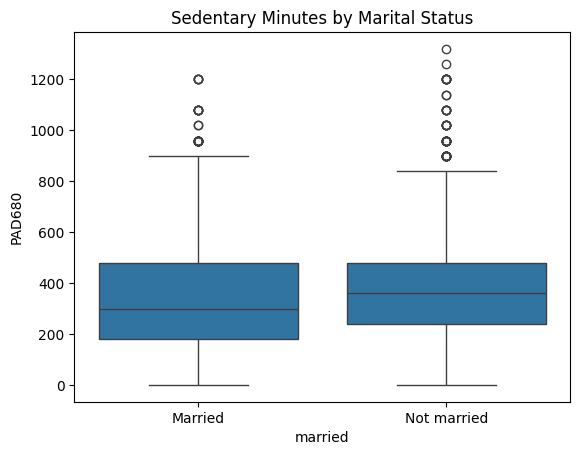

In [17]:
# Question 2
# Is there a difference in the mean sedentary behavior time
# between those who are married and those who are not married?
married_group = data[data['married']=='Married']['PAD680'].dropna()
not_married_group = data[data['married']=='Not married']['PAD680'].dropna()
t_stat, p_val = stats.ttest_ind(married_group, not_married_group)
print("\nQuestion 2: T-test for sedentary time by marital status")
print("T =", t_stat, "p-value =", p_val)
print("Mean (Married):", married_group.mean())
print("Mean (Not married):", not_married_group.mean())
if p_val < 0.05:
    print("Significant difference in sedentary time between married and not married groups.")
else:
    print("No significant difference in sedentary time between married and not married groups.")
sns.boxplot(x='married', y='PAD680', data=data)
plt.title('Sedentary Minutes by Marital Status')
plt.show()

In [18]:
# Question 3
# How do age and marital status affect systolic blood pressure?
model = ols('BPXOSY3 ~ RIDAGEYR + married', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nQuestion 3: ANOVA (Age + Marital Status on Systolic BP)")
print(anova_table)
if (anova_table['PR(>F)'] < 0.05).any():
    print("At least one variable significantly affects systolic blood pressure.")
else:
    print("No significant effect of age or marital status on systolic blood pressure.")



Question 3: ANOVA (Age + Marital Status on Systolic BP)
                sum_sq      df           F         PR(>F)
married   2.535718e+03     1.0    8.683421   3.224107e-03
RIDAGEYR  2.581947e+05     1.0  884.173152  7.927861e-181
Residual  1.674725e+06  5735.0         NaN            NaN
At least one variable significantly affects systolic blood pressure.



Question 4: Correlation between weight and sedentary minutes
r = 0.15390351668617425 p-value = 9.43330828208821e-32
Significant correlation between weight and sedentary time.


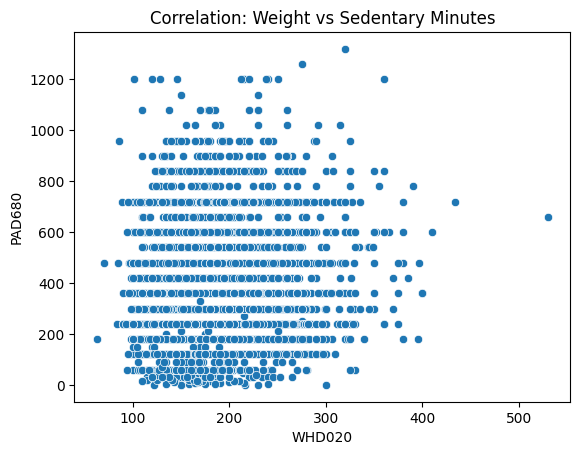

In [23]:
# Question 4
# Is there a correlation between self-reported weight and minutes of sedentary behavior?
clean = data[['WHD020','PAD680']].dropna()
r, p = stats.pearsonr(clean['WHD020'], clean['PAD680'])
print("\nQuestion 4: Correlation between weight and sedentary minutes")
print("r =", r, "p-value =", p)
if p < 0.05:
    print("Significant correlation between weight and sedentary time.")
else:
    print("No significant correlation between weight and sedentary time.")
sns.scatterplot(x='WHD020', y='PAD680', data=clean)
plt.title('Correlation: Weight vs Sedentary Minutes')
plt.show()


Question 5: T-test for kidney condition and systolic BP
T = 3.135956560429108 p-value = 0.001721607022774874
Mean (Kidney problem): 126.55045871559633
Mean (No problem): 122.5786231884058
People with weak/failing kidneys have significantly higher systolic blood pressure.


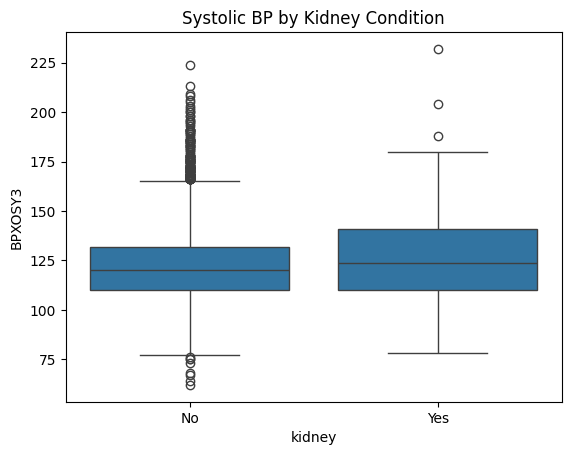

In [24]:
# Question 5
# Do people with weak or failing kidneys have higher systolic blood pressure than those without?
yes_kidney = data[data['kidney']=='Yes']['BPXOSY3'].dropna()
no_kidney = data[data['kidney']=='No']['BPXOSY3'].dropna()
t_stat2, p_val2 = stats.ttest_ind(yes_kidney, no_kidney)
print("\nQuestion 5: T-test for kidney condition and systolic BP")
print("T =", t_stat2, "p-value =", p_val2)
print("Mean (Kidney problem):", yes_kidney.mean())
print("Mean (No problem):", no_kidney.mean())
if p_val2 < 0.05:
    print("People with weak/failing kidneys have significantly higher systolic blood pressure.")
else:
    print("No significant difference in systolic blood pressure by kidney condition.")
sns.boxplot(x='kidney', y='BPXOSY3', data=data)
plt.title('Systolic BP by Kidney Condition')
plt.show()

